<a href="https://colab.research.google.com/github/Eunhui-Kim/Data-Science-TM/blob/master/An_introduction_to_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to Jax

In this workshop, we're going to run through an introduction to Jax - and some of the recent features. 

In short - Jax is accelerated, differentiable, and trivially parallelisable numpy.

Just-in-time (JIT) XLA compilation makes it natively fast without having to write custom kernels to fuse your code. Native parallelism means that the same code runs on anywhere from 1 to thousands of devices, and all you need to do is define the partitioning patterns - no frameworks necessary.

To really squeeze out peformance, if you'd like to optimise even further, you can define the exact collective operations occuring by working on a per device level within any given function, or by writing custom kernels with Jax-Triton.

We're going to start with an illustrative example, then build back up to that by learning all the core pieces.

Note that this colab runs on CPU so that we can spoof multiple devices and show case the parallelism APIs without needing to spin up GPU/TPUs. 



In [ ]:
# @title Installs: install and restarts, don't run the second time!
%pip install --upgrade matplotlib -q
%pip install rich -q
from google.colab import runtime
quit()

     |████████████████████████████████| 11.2 MB 4.8 MB/s 
     |████████████████████████████████| 965 kB 47.3 MB/s 
     |████████████████████████████████| 237 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 


In [1]:
import os

import functools
from typing import Optional

import numpy as np

import jax
import jax.numpy as jnp
import matplotlib.cm
jax.config.update('jax_array', True) # A new parallelism supporting feature!
from jax.experimental import maps
from jax.experimental import PartitionSpec as P
from jax.experimental import mesh_utils
from jax.sharding import NamedSharding

In [ ]:
# @title Spoof multiple devices
import re
def set_host_device_count(n):
  xla_flags = os.getenv('XLA_FLAGS', '')
  xla_flags = re.sub(
      r'--xla_force_host_platform_device_count=\S+', '', xla_flags
  ).split()
  os.environ['XLA_FLAGS'] = ' '.join(
      ['--xla_force_host_platform_device_count={}'.format(n)] + xla_flags
  )
set_host_device_count(8)
devices = jax.devices()
print(f"Spoof {len(devices)} devices: {devices}")

Spoof 8 devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# 1. Motivating example - a simple model and data parallel MLP

In [2]:
# Order our devices to respect our desired topology
# this is important on TPUs to ensure hops are efficient
devices = mesh_utils.create_device_mesh((4, 2))
# create a mesh from our 8 devices and name both axes this can
# be multi-dimensional, and extend to arbitary numbers of devices
mesh = maps.Mesh(devices, axis_names=('x', 'y'))

ValueError: ignored

In [ ]:
def predict(params, inputs):
  """Performs a forward pass through the model."""
  # Same API as numpy
  for W, b in params:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  return outputs

def loss(params, inputs, targets):
  """MSE loss."""
  predictions = predict(params, inputs)
  return jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))

In [ ]:
# Compiled and differentiable function composition
loss_jit = jax.jit(loss)
gradfun = jax.jit(jax.grad(loss))

In [ ]:
def init_layer(key, n_in, n_out, model_parallel=True):
  """Creates a weight and bias param."""
  k1, k2 = jax.random.split(key)
  W = jax.random.normal(k1, (n_in, n_out)) / jnp.sqrt(n_in)
  b = jax.random.normal(k2, (n_out,))
  if model_parallel:
    W = jax.device_put(W, NamedSharding(mesh, P('y', None)))
  return W, b

def init_model(key, layer_sizes, batch_size):
  """Creates both parameters and example inputs/target."""
  # determinism guarantees through explicit RNG keys
  key, *keys = jax.random.split(key, len(layer_sizes))
  params = list(map(init_layer, keys, layer_sizes[:-1], layer_sizes[1:]))

    
  key, *keys = jax.random.split(key, 3)
  inputs = jax.random.normal(keys[0], (batch_size, layer_sizes[0]))
  targets = jax.random.normal(keys[1], (batch_size, layer_sizes[-1]))

  return params, (inputs, targets)

# small sizes so that this example runs on CPU
layer_sizes = [32, 64, 64, 32, 10]
batch_size = 16

params, (inputs, targets) = init_model(jax.random.PRNGKey(0), layer_sizes, batch_size)

In [ ]:
# batch is shaped [batch, embedding]
# split batch over the x axis of our hardware mesh
# similarly, we could split our model parameters 
inputs = jax.device_put(inputs, NamedSharding(mesh, P('x', None)))
jax.debug.visualize_array_sharding(inputs)

                                                  
                     CPU 0,1                      
                                                  
                                                  
                     CPU 2,3                      
                                                  
                                                  
                     CPU 4,5                      
                                                  
                                                  
                     CPU 6,7                      
                                                  

In [ ]:
# We can also note that our params are sharded across the y axis of the mesh
jax.debug.visualize_array_sharding(params[0][0])

                                                  
                                                  
                   CPU 0,2,4,6                    
                                                  
                                                  
                                                  
                                                  
                                                  
                   CPU 1,3,5,7                    
                                                  
                                                  
                                                  

In [ ]:
loss_jit(params, inputs, targets)

Array(18.977833, dtype=float32)

In [ ]:
step_size = 3e-4

for _ in range(30):
  grads = gradfun(params, inputs, targets)
  # interprets two data structures as trees, applies the same function to 
  # all comparable 'leaves' of the trees
  params = jax.tree_map(lambda W, dw: W - step_size * dw, params, grads)


print(loss_jit(params, inputs, targets))

12.564707


# Is this representative of  real models? Yes!
- You can use flax for a pytorch style API
- Even in pure Jax, you can define transformers really elegantly. I've used this to make a minimal PaLM - which we then optimised. It gave us explicit control over our tensors.

In [ ]:
# For example!
def fprop_layer(x_spec, params, x):
  """Forward pass through a single transformer layer."""
  qkv, o, wi, wo = params
  x = with_sharding_constraint(x, x_spec)
  xnorm = jax.nn.normalize(x)
  q, k, v = jnp.einsum('bte,iehq->ibthq', xnorm, qkv)
  outer = jnp.einsum('bshq,bthq->bsth', q, k)
  alpha = jax.nn.softmax(outer, 2)
  inner = jnp.einsum('bsth,bthq->bshq', alpha, v)
  y = jnp.einsum('bthq,hqe->bte', inner, o)
  x = with_sharding_constraint(x + y, x_spec)
  xnorm = jax.nn.normalize(x)
  act = jnp.tanh(jnp.einsum('bte,ef->btf', xnorm, wi))
  z = jnp.einsum('btf,fe->bte', act, wo)
  return with_sharding_constraint(x + z, x_spec)

# 2.  Building up from the basics!

Think of JAX as differentiable NumPy that runs on accelerators.



In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


Computations in Jax are asynchronously dispatched to your accelerator - this prevents long running computations from blocking the queue - but it does mean that when using an accelerator you should use *block_until_ready* to properly time your functions.

In [ ]:
long_vector = jnp.arange(int(1e4))

jnp.dot(long_vector, long_vector).block_until_ready()

Array(-1724114088, dtype=int32)

## JAX first transformation: `grad`

A fundamental feature of JAX is that it allows you to transform functions.

One of the most commonly used transformations is `jax.grad`, which takes a numerical function written in Python and returns you a new Python function that computes the gradient of the original function. 

To use it, let's first define a function that takes an array and returns the sum of squares.


In [ ]:
def sum_of_squares(x):
  return jnp.sum(x**2)

Applying `jax.grad` to `sum_of_squares` will return a different function, namely the gradient of `sum_of_squares` with respect to its first parameter `x`. 

Then, you can use that function on an array to return the derivatives with respect to each element of the array.

In [ ]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


You can think of `jax.grad` by analogy to the $\nabla$ operator from vector calculus. Given a function $f(x)$, $\nabla f$ represents the function that computes $f$'s gradient, i.e.

$$
(\nabla f)(x)_i = \frac{\partial f}{\partial x_i}(x).
$$

Analogously, `jax.grad(f)` is the function that computes the gradient, so `jax.grad(f)(x)` is the gradient of `f` at `x`.

(Like $\nabla$, `jax.grad` will only work on functions with a scalar output -- it will raise an error otherwise.)

This makes the JAX API quite different from other autodiff libraries like Tensorflow and PyTorch, where to compute the gradient we use the loss tensor itself (e.g. by calling `loss.backward()`). The JAX API works directly with functions, staying closer to the underlying math. Once you become accustomed to this way of doing things, it feels natural: your loss function in code really is a function of parameters and data, and you find its gradient just like you would in the math.

This way of doing things makes it straightforward to control things like which variables to differentiate with respect to. By default, `jax.grad` will find the gradient with respect to the first argument. In the example below, the result of `sum_squared_error_dx` will be the gradient of `sum_squared_error` with respect to `x`.

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


To find the gradient with respect to a different argument (or several), you can set `argnums`:

In [ ]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

Does this mean that when doing machine learning, we need to write functions with gigantic argument lists, with an argument for each model parameter array? No. JAX comes equipped with machinery for bundling arrays together in data structures called 'pytrees', on which more in a [later guide](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb). So, most often, use of `jax.grad` looks like this:

```
def loss_fn(params, data):
  ...

grads = jax.grad(loss_fn)(params, data_batch)
```

## Value and Grad

Often, you need to find both the value and the gradient of a function, e.g. if you want to log the training loss. JAX has a handy sister transformation for efficiently doing that:

In [ ]:
jax.value_and_grad(sum_squared_error)(x, y)

(Array(0.03999995, dtype=float32),
 Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

which returns a tuple of, you guessed it, (value, grad). To be precise, for any `f`,

```
jax.value_and_grad(f)(*xs) == (f(*xs), jax.grad(f)(*xs)) 
```

## Differences from NumPy

The `jax.numpy` API closely follows that of NumPy. However, there are some important differences. We cover many of these in future guides, but it's worth pointing some out now.

The most important difference, and in some sense the root of all the rest, is that JAX is designed to be _functional_, as in _functional programming_. The reason behind this is that the kinds of program transformations that JAX enables are much more feasible in functional-style programs.

An introduction to functional programming (FP) is out of scope of this guide. If you already are familiar with FP, you will find your FP intuition helpful while learning JAX. If not, don't worry! The important feature of functional programming to grok when working with JAX is very simple: don't write code with side-effects.

A side-effect is any effect of a function that doesn't appear in its output. One example is modifying an array in place:

In [ ]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

The side-effectful function modifies its argument, but returns a completely unrelated value. The modification is a side-effect. 

The code below will run in NumPy. However, JAX arrays won't allow themselves to be modified in-place:

In [ ]:
in_place_modify(jnp.array(x))  # Raises error when we cast input to jnp.ndarray

TypeError: ignored

Helpfully, the error points us to JAX's side-effect-free way of doing the same thing via the [`jax.numpy.ndarray.at`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html) index update operators (be careful [`jax.ops.index_*`](https://jax.readthedocs.io/en/latest/jax.ops.html#indexed-update-functions-deprecated) functions are deprecated). They are analogous to in-place modification by index, but create a new array with the corresponding modifications made:

In [ ]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

Array([123,   2,   3], dtype=int32)

Note that the old array was untouched, so there is no side-effect:

In [ ]:
y

Array([1, 2, 3], dtype=int32)

Side-effect-free code is sometimes called *functionally pure*, or just *pure*.

Isn't the pure version less efficient? Strictly, yes; we are creating a new array. However, as we will explain in the next guide, JAX computations are often compiled before being run using another program transformation, `jax.jit`. If we don't use the old array after modifying it 'in place' using indexed update operators, the compiler can recognise that it can in fact compile to an in-place modify, resulting in efficient code in the end.

Of course, it's possible to mix side-effectful Python code and functionally pure JAX code, and we will touch on this more later. As you get more familiar with JAX, you will learn how and when this can work. As a rule of thumb, however, any functions intended to be transformed by JAX should avoid side-effects, and the JAX primitives themselves will try to help you do that.

## Your first JAX training loop

You already know enough to understand how we can use JAX to build a simple training loop.

To keep things simple, we'll start with a linear regression. 

Our data is sampled according to $y = w_{true} x + b_{true} + \epsilon$.

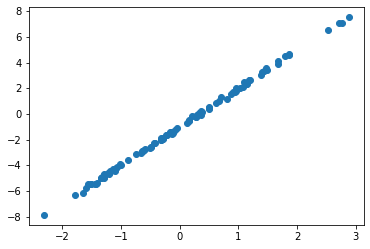

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

Therefore, our model is $\hat y(x; \theta) = wx + b$.

We will use a single array, `theta = [w, b]` to house both parameters:

In [ ]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

The loss function is $J(x, y; \theta) = (\hat y - y)^2$.

In [ ]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

How do we optimize a loss function? Using gradient descent. At each update step, we will find the gradient of the loss w.r.t. the parameters, and take a small step in the direction of steepest descent:

$\theta_{new} = \theta - 0.1 (\nabla_\theta J) (x, y; \theta)$

In [ ]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In JAX, it's common to define an `update()` function that is called every step, taking the current parameters as input and returning the new parameters. This is a natural consequence of JAX's functional nature, and is explained in more detail in [The Problem of State](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb).

This function can then be JIT-compiled in its entirety for maximum efficiency. The next guide will explain exactly how `jax.jit` works, but if you want to, you can try adding `@jax.jit` before the `update()` definition, and see how the training loop below runs much faster.

w: 2.99, b: -1.00


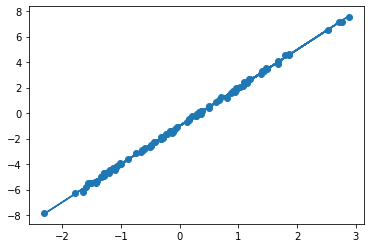

In [ ]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

# Just In Time Compilation with JAX

In this section, we will further explore how JAX works, and how we can make it performant.
We will discuss the `jax.jit()` transform, which will perform *Just In Time* (JIT) compilation
of a JAX Python function so it can be executed efficiently in XLA.

**Question to the room: Does anyone know the major considerations in what makes code fast on accelerators?**

## How JAX transforms work

In the previous section, we discussed that JAX allows us to transform Python functions. This is done by first converting the Python function into a simple intermediate language called jaxpr. The transformations then work on the jaxpr representation. 

We can show a representation of the jaxpr of a function by using `jax.make_jaxpr`:

In [ ]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


We can look at jitting in the context of our previous linear regression model. You can see that the entire

In [ ]:
jitted_update_fn = jax.jit(update)
jax.make_jaxpr(jitted_update_fn)(theta, xs, ys)

{ lambda ; a:f32[2] b:f32[100] c:f32[100]. let
    d:f32[2] = xla_call[
      call_jaxpr={ lambda ; e:f32[2] f:f32[100] g:f32[100]. let
          h:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] e
          i:f32[] = squeeze[dimensions=(0,)] h
          j:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] e
          k:f32[] = squeeze[dimensions=(0,)] j
          l:f32[100] = mul i f
          m:f32[100] = add l k
          n:f32[100] = sub m g
          o:f32[100] = integer_pow[y=2] n
          p:f32[100] = integer_pow[y=1] n
          q:f32[100] = mul 2.0 p
          r:f32[] = reduce_sum[axes=(0,)] o
          _:f32[] = div r 100.0
          s:f32[] = div 1.0 100.0
          t:f32[100] = broadcast_in_dim[broadcast_dimensions=() shape=(100,)] s
          u:f32[100] = mul t q
          v:f32[] = reduce_sum[axes=(0,)] u
          w:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] v
          x:f32[2] = pad[padding_config=((1, 0, 0),)] w 0

Jitting wraps the entire update function in an 'xla_call', which means that the entire thing is eventually compiled and optimised by XLA. This often results in dramatic speed ups, because instead of returning tensors to the accelerator memory (or worse, host memory!), the compiler can optimise the computations to occur together where possible, keeping things in faster memory on the chip.

This also means that we can get a good idea of the cost and memory require by our functions, by compiling ahead of time! This makes optimising a little bit easier.

In [ ]:
jitted_update_fn.lower(theta, xs, ys).compile().cost_analysis()

[{'bytes accessed': 3304.0,
  'bytes accessed operand 0 {}': 1608.0,
  'bytes accessed operand 1 {}': 432.0,
  'bytes accessed operand 2 {}': 424.0,
  'bytes accessed output {}': 840.0,
  'flops': 1160.0,
  'optimal_seconds': 0.0,
  'utilization operand 0 {}': 5.0,
  'utilization operand 1 {}': 5.0,
  'utilization operand 2 {}': 3.0}]

You can then call the function just as you would any other function - but now it will be much faster. Jit caches calls to the function with the same input shapes, but will need to re-trace if you use different shapes. This is a sharp edge, but one that is in the progress of being solved with dynamic shapes (and worth the payoff of faster code)

In [ ]:
theta = jitted_update_fn(theta, xs, ys)

However, compiling complicated programs can be slow - because it is a difficult optimisation problem, and compiled programs can not have explicit if-else branching in them (if necessary, use jax.lax.cond).

For most modern models, which are a stack of similar layers - these compile times can be dramatically reduced by using Jax's internal for loop to tell the compiler each layer is the same (it doesn't know this with a standard for loop), so it typically isn't a huge concern.


# Parallelism with Jax

Now that we have some experience working with Jax, lets take a look at one of the key features relevant to modern machine learning, parallelism!

Parallelism is important even if you have two chips - this can allow you to experiment with infernece using much larger models, or train more efficiently. It also allows you to easily use the same code if you want to explore scaling your models on more devices, once you have the ideas right!

## What even is partitioning?

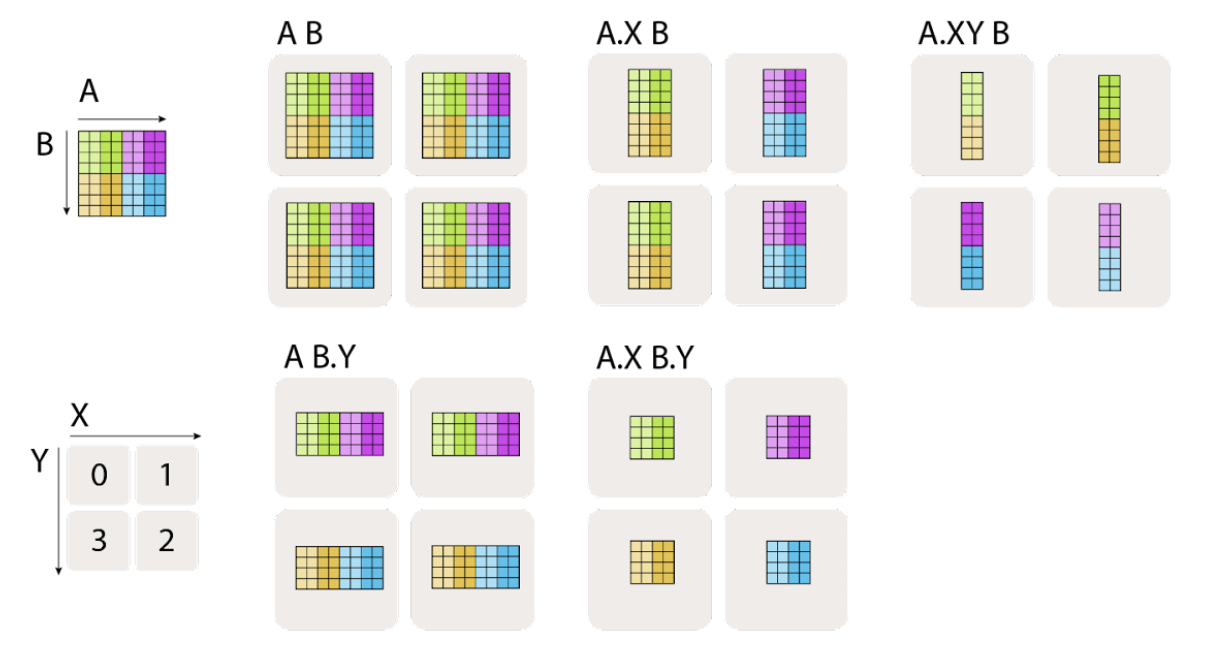

In Jax, we think of partioning 'logical dimensions' of a tensor (like A and B) over hardware dimensions of a mesh of chips (like X and Y). 'Data parallelism' is just partitioning the batch axis of your inputs over one of your hardware axes. Model parallelism is the same, but for one or more dimensions of your weights. ZeRO style update sharding is the same, but sharding the layers dimension of your weights!

In JAX, Sharding objects describe distributed memory layouts. They can be used with jax.device_put to produce a value with distributed layout.

For example, here’s a value with a single-device Sharding:

In [ ]:
import jax
x = jnp.arange(16).reshape(4,4)

Here, we’re using the jax.debug.visualize_array_sharding function to show where the value x is stored in memory. All of x is stored on a single device, so the visualization is pretty boring!

But we can shard x across multiple devices by using jax.device_put and a Sharding object. First, we make a numpy.ndarray of Devices using mesh_utils.create_device_mesh, which takes hardware topology into account for the Device order:

In [ ]:
jax.debug.visualize_array_sharding(x)

                         
                         
                         
                         
                         
          CPU 0          
                         
                         
                         
                         
                         

In [ ]:
# Order our devices to respect our desired topology
# this is important on TPUs to ensure hops are efficient
devices = mesh_utils.create_device_mesh((4, 2))
# create a mesh from our 8 devices and name both axes this can
# be multi-dimensional, and extend to arbitary numbers of devices
mesh = maps.Mesh(devices, axis_names=('x', 'y'))

In [ ]:
# batch is shaped [batch, embedding]
# split batch over the x axis of our hardware mesh
# similarly, we could split our model parameters 
y = jax.device_put(x, NamedSharding(mesh, P('x', 'y'))) # like A.x, B.y
jax.debug.visualize_array_sharding(y)

                        
   CPU 0       CPU 1    
                        
                        
   CPU 2       CPU 3    
                        
                        
   CPU 4       CPU 5    
                        
                        
   CPU 6       CPU 7    
                        

In [ ]:
print(y)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [ ]:
print(y.device_buffers[0]) # this is what is actually on our first device

[[0 1]]


Computation now follows the tensors. If we call a function on distributed tensors, the computation and results will all be distributed

In [ ]:
z = jnp.sin(y)
jax.debug.visualize_array_sharding(z)

                        
   CPU 0       CPU 1    
                        
                        
   CPU 2       CPU 3    
                        
                        
   CPU 4       CPU 5    
                        
                        
   CPU 6       CPU 7    
                        

If you don't shard one of the dimensions, it is implictly 'replicated' i.e. copied across that dimension. You do this by specifying None for that dimension.

In [ ]:
y = jax.device_put(x, NamedSharding(mesh, P('x', None))) # like A.x, B.y
jax.debug.visualize_array_sharding(y)

                         
         CPU 0,1         
                         
                         
         CPU 2,3         
                         
                         
         CPU 4,5         
                         
                         
         CPU 6,7         
                         

The compiler automatically handles how to do communication if distributed tensors require it for the computation.

In [ ]:
y = jax.device_put(x, NamedSharding(mesh, P('x', None)))
z = jax.device_put(x, NamedSharding(mesh, P(None, 'y')))
print('lhs sharding:')
jax.debug.visualize_array_sharding(y)
print('rhs sharding:')
jax.debug.visualize_array_sharding(z)

w = jnp.dot(y, z)
print('out sharding:')
jax.debug.visualize_array_sharding(w)

lhs sharding:


                         
         CPU 0,1         
                         
                         
         CPU 2,3         
                         
                         
         CPU 4,5         
                         
                         
         CPU 6,7         
                         

rhs sharding:


                        
                        
                        
                        
                        
CPU 0,2,4,6 CPU 1,3,5,7 
                        
                        
                        
                        
                        

out sharding:


                        
   CPU 0       CPU 1    
                        
                        
   CPU 2       CPU 3    
                        
                        
   CPU 4       CPU 5    
                        
                        
   CPU 6       CPU 7    
                        

In [ ]:
w, w.device_buffers[0]

(Array([[ 56,  62,  68,  74],
        [152, 174, 196, 218],
        [248, 286, 324, 362],
        [344, 398, 452, 506]], dtype=int32), Array([[56, 62]], dtype=int32))

What is actually happening under the hood?

You'll notice if we do y @ z, its a pretty simple program because it is all chip local! But if we do z @ y, then the compiler inserts 'all-gathers' for us under the hood, communicating data across chips.

In [ ]:
print(jax.jit(jnp.dot).lower(z, y).compile().as_text())

HloModule jit_dot, entry_computation_layout={(s32[4,2]{1,0},s32[1,4]{1,0})->s32[4,4]{1,0}}, allow_spmd_sharding_propagation_to_output=true

%add (x: s32[], y: s32[]) -> s32[] {
  %x = s32[] parameter(0)
  %y = s32[] parameter(1)
  ROOT %add.1 = s32[] add(s32[] %x, s32[] %y)
}

%add.1 (x.1: s32[], y.1: s32[]) -> s32[] {
  %x.1 = s32[] parameter(0)
  %y.1 = s32[] parameter(1)
  ROOT %add.3 = s32[] add(s32[] %x.1, s32[] %y.1)
}

%fused_computation (param_0.1: s32[1,4], param_1.1: u32[], param_2.3: u32[]) -> s32[4,4] {
  %constant.13 = s32[] constant(0)
  %broadcast.2 = s32[4,4]{1,0} broadcast(s32[] %constant.13), dimensions={}
  %param_0.1 = s32[1,4]{1,0} parameter(0)
  %constant.10 = u32[8]{0} constant({0, 0, 1, 1, 2, 2, 3, 3})
  %param_2.3 = u32[] parameter(2)
  %constant.11 = u32[] constant(8)
  %multiply.4 = u32[] multiply(u32[] %param_2.3, u32[] %constant.11)
  %param_1.1 = u32[] parameter(1)
  %add.4 = u32[] add(u32[] %multiply.4, u32[] %param_1.1)
  %dynamic-slice.2 = u32[1]{0} dyn

# Lets go back up to our model example!